# Обучение ResNet и EfficientNet

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from PIL import Image

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
from torch import nn
from torch.nn import functional as F
import os

from tqdm.notebook import tqdm

from torchvision import datasets, models, transforms
from efficientnet_pytorch import EfficientNet

import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

In [2]:
import os
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train', val_size=0.2, test_size=0.2, random_state=42):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.val_size = val_size
        self.test_size = test_size
        self.random_state = random_state
        self.images = []
        self.labels = []
        self.class_names = sorted(os.listdir(root_dir))
        
        for i, class_name in enumerate(self.class_names):
            class_dir = os.path.join(root_dir, class_name)
            class_images = [os.path.join(class_dir, file_name) for file_name in os.listdir(class_dir) if file_name.endswith('.jpg') or file_name.endswith('.png')]
            class_labels = [i] * len(class_images)
            self.images.extend(class_images)
            self.labels.extend(class_labels)
        
        self.images, self.labels = self.split_data(self.images, self.labels)

    def split_data(self, images, labels):
        train_images, tmp_images, train_labels, tmp_labels = train_test_split(images, labels, test_size=self.val_size+self.test_size, random_state=self.random_state)
        val_images, test_images, val_labels, test_labels = train_test_split(tmp_images, tmp_labels, test_size=self.test_size/(self.val_size+self.test_size), random_state=self.random_state)
        
        if self.split == 'train':
            return train_images, train_labels
        elif self.split == 'val':
            return val_images, val_labels
        else:
            return test_images, test_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx] - 1
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [3]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

In [4]:
train_dataset = MyDataset('/home/jupyter/datasphere/project/dataset_crop/train', transform=data_transforms, split='train', val_size=0.2, test_size=0.2, random_state=42)
val_dataset = MyDataset('/home/jupyter/datasphere/project/dataset_crop/train', transform=data_transforms, split='val', val_size=0.2, test_size=0.2, random_state=42)
test_dataset = MyDataset('/home/jupyter/datasphere/project/dataset_crop/train', transform=data_transforms, split='test', val_size=0.2, test_size=0.2, random_state=42)


In [5]:
dataloaders = {}
dataloaders['train'] = DataLoader(train_dataset, batch_size=16,
                                  shuffle=True)
dataloaders['valid'] = DataLoader(val_dataset, batch_size=128,
                                  shuffle=False)
dataloaders['test'] = DataLoader(test_dataset, batch_size=128,
                                 shuffle=False)

In [10]:
def train(model, loaders, criterion, optimizer, scheduler, epochs=100):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    metrics = {"train": [], "valid": []}
    losses = {"train": [], "valid": []}
    model.to(device)
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}")

        for k, dataloader in loaders.items():
            loss_batch = []
            run_loss, run_metric, all, count = 0, 0, 0, 0

            for x_batch, y_batch in tqdm(dataloader):
                x_batch = x_batch.to(device)
                y_batch = y_batch.long().to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    loss_batch.append(loss.item())
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                        loss = criterion(outp, y_batch)
                        loss_batch.append(loss.item())

                run_loss += loss.item()
                run_metric += (outp.argmax(1) == y_batch).sum().item()
                all += y_batch.shape[0]
                count += 1

            epoch_loss = run_loss / count
            epoch_metric = run_metric / all

            metrics[k].append(epoch_metric)
            losses[k].append(epoch_loss)

            print(f"Loader: {k:<10}Accuracy: {epoch_metric:<20}Loss: {epoch_loss:<20}")

    return metrics, losses

## Обучение моделей 

In [18]:
model = EfficientNet.from_pretrained(f'efficientnet-b7')

model._fc = nn.Sequential(
    nn.Linear(model._fc.in_features, 3),
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:07<00:00, 38.0MB/s] 


Loaded pretrained weights for efficientnet-b7


In [11]:
model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 3),

)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loaders = {"train": dataloaders['train'], 'valid': dataloaders['valid']}

In [20]:
metrics, losses = train(model, loaders, criterion, optimizer, scheduler, 10)

Epoch: 1


  0%|          | 0/599 [00:00<?, ?it/s]

Loader: train     Accuracy: 0.7862061769616027  Loss: 0.5841254927280152  


  0%|          | 0/25 [00:00<?, ?it/s]

Loader: valid     Accuracy: 0.8128325508607199  Loss: 0.5355845212936401  
Epoch: 2


  0%|          | 0/599 [00:00<?, ?it/s]

Loader: train     Accuracy: 0.8368113522537562  Loss: 0.4688576224053244  


  0%|          | 0/25 [00:00<?, ?it/s]

Loader: valid     Accuracy: 0.8557120500782472  Loss: 0.4444792032241821  
Epoch: 3


  0%|          | 0/599 [00:00<?, ?it/s]

Loader: train     Accuracy: 0.8582011686143572  Loss: 0.4158546630734693  


  0%|          | 0/25 [00:00<?, ?it/s]

Loader: valid     Accuracy: 0.860093896713615   Loss: 0.40644989013671873 
Epoch: 4


  0%|          | 0/599 [00:00<?, ?it/s]

Loader: train     Accuracy: 0.8755217028380634  Loss: 0.36990622848968874 


  0%|          | 0/25 [00:00<?, ?it/s]

Loader: valid     Accuracy: 0.8610328638497653  Loss: 0.4468469226360321  
Epoch: 5


  0%|          | 0/599 [00:00<?, ?it/s]

Loader: train     Accuracy: 0.8891903171953256  Loss: 0.3242483669285583  


  0%|          | 0/25 [00:00<?, ?it/s]

Loader: valid     Accuracy: 0.8453834115805947  Loss: 0.4580258715152741  
Epoch: 6


  0%|          | 0/599 [00:00<?, ?it/s]

Loader: train     Accuracy: 0.9079716193656093  Loss: 0.2723768296059165  


  0%|          | 0/25 [00:00<?, ?it/s]

Loader: valid     Accuracy: 0.8697965571205007  Loss: 0.41557629346847536 
Epoch: 7


  0%|          | 0/599 [00:00<?, ?it/s]

Loader: train     Accuracy: 0.9148580968280468  Loss: 0.24362208780355266 


  0%|          | 0/25 [00:00<?, ?it/s]

Loader: valid     Accuracy: 0.8575899843505478  Loss: 0.5321127510070801  
Epoch: 8


  0%|          | 0/599 [00:00<?, ?it/s]

Loader: train     Accuracy: 0.9233096828046744  Loss: 0.22348538369176682 


  0%|          | 0/25 [00:00<?, ?it/s]

Loader: valid     Accuracy: 0.8622848200312989  Loss: 0.4780954599380493  
Epoch: 9


  0%|          | 0/599 [00:00<?, ?it/s]

Loader: train     Accuracy: 0.9400041736227045  Loss: 0.17742728693908288 


  0%|          | 0/25 [00:00<?, ?it/s]

Loader: valid     Accuracy: 0.8591549295774648  Loss: 0.5125101041793824  
Epoch: 10


  0%|          | 0/599 [00:00<?, ?it/s]

Loader: train     Accuracy: 0.9479340567612687  Loss: 0.15707936987221763 


  0%|          | 0/25 [00:00<?, ?it/s]

Loader: valid     Accuracy: 0.8435054773082942  Loss: 0.6569067454338073  


<Figure size 864x576 with 0 Axes>

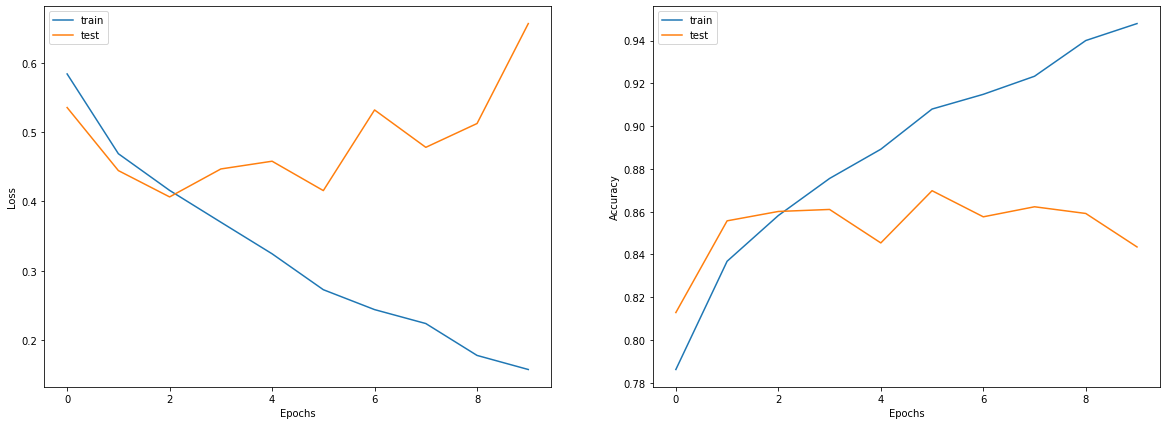

In [21]:
plt.figure(figsize=(12, 8))
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(losses['train'])), losses['train'], label='train')
plt.plot(range(len(losses['valid'])), losses['valid'], label='test')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(len(metrics['train'])), metrics['train'], label='train')
plt.plot(range(len(metrics['valid'])), metrics['valid'], label='test')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend();

## Оценка модели

In [22]:
from sklearn.metrics import classification_report

y_pred, y_test = [], []
model.eval()
with torch.no_grad():
    for x_batch, y_batch in dataloaders['test']:
        x_batch = x_batch.to(device)
        outp = model(x_batch)
        y_pred += list(outp.cpu().numpy().argmax(1))
        y_test += list(y_batch)

print(classification_report(y_test, y_pred, digits=5))

              precision    recall  f1-score   support

           0    0.79661   0.58385   0.67384       644
           1    0.81818   0.71083   0.76074       785
           2    0.84076   0.97169   0.90150      1766

    accuracy                        0.82942      3195
   macro avg    0.81852   0.75546   0.77869      3195
weighted avg    0.82632   0.82942   0.82102      3195



## Сохранение модели

In [23]:
import torch

res_output_file = './ResNet_crop_best.pth'
torch.save(model, res_output_file)

In [50]:

effic_output_file = './EfficientNet_crop_best.pth'
torch.save(model, effic_output_file)